In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
from yahooquery import Ticker
import time

In [2]:
#importando base
df_ibrx = pd.read_excel(r'C:\Users\drsan\OneDrive\Área de Trabalho\Python\ETFs_Onshore.xlsx',sheet_name = 'IBRX100')
df_ibrx.head()

,Código,Ação,Tipo,Qtde. Teórica,Part. (%),Setor,Subsetor,Segmento
0,ABEV3,AMBEV S/A,ON,4.354.228.928,2936.0,Consumo não Cíclico,Bebidas,Cervejas e Refrigerantes
1,ALPA4,ALPARGATAS,PN N1,187.007.704,328.0,Consumo Cíclico,"Tecidos, Vestuário e Calçados",Calçados
2,ALSO3,ALIANSCSONAE,ON NM,127.374.163,186.0,Financeiro,Exploração de Imóveis,Exploração de Imóveis
3,AZUL4,AZUL,PN N2,317.471.474,363.0,Bens Industriais,Transporte,Transporte Aéreo
4,B3SA3,B3,ON NM,2.046.021.644,6301.0,Financeiro,Serviços Financeiros Diversos,Serviços Financeiros Diversos


In [3]:
# dando aquele tapa
df = df_ibrx
df = pd.DataFrame(df) 
df = df.dropna()
df['Part. (%)'] /= 100000
df.rename(columns={'Código\xa0':'Codigo'}, inplace = True)
df['Codigo'] = df['Codigo'] + ".SA"
tickers = df['Codigo']

In [4]:
#auxiliares estrategias
def stochastic(x,a,b):
    # x = matriz de precos
    # a = periodo stochastic
    # b = signal
    df = x.copy()
    df['%K'] = (df['Close']-df['Low'].rolling(a).min())/(df['High'].rolling(a).max()-df['Low'].rolling(a).min())*100
    df['%D'] = df['%K'].rolling(b).mean()
    return df

def MACD(x,a,b,c):
    # x = matriz de precos
    # a = fast mov avg
    # b = slow mov avg
    # c = signal
    df = x.copy()
    df['MACD'] = df['Close'].ewm(span=a).mean() - df['Close'].ewm(span=b).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=c).mean()
    return df

def SMA(x,a,b):
    # x = matriz de precos
    # a = fast mov avg
    # b = slow mov avg
    df = x.copy()
    df['SMA_Fast'] = df['Close'].rolling(a).mean()
    df['SMA_Slow'] = df['Close'].rolling(b).mean()
    return df

def EMA(x,a,b):
    # x = matriz de precos
    # a = fast mov avg
    # b = slow mov avg
    df = x.copy()
    df['EMA_Fast'] = df['Close'].ewm(span=a).mean()
    df['EMA_Slow'] = df['Close'].ewm(span=b).mean()
    return df

def desvpad(x,a):
    # x = matriz de precos
    # a = mov avg
    df = x.copy()
    df['std'] = df['Close'].rolling(a).std()
    return df

In [5]:
def trades(x,y):
    # x = matriz de precos com trade_signal
    # y e o ativo
    df = x.copy()
    df_trades = pd.DataFrame(columns=['ativo','direcao','data_entrada','preco_entrada','data_saida','preco_saida','periodos'])
    ativo = y
    
    for i in range(len(df)):
        
        if i == 0:
            if df['trade_signal'][i] == 'Buy' or df['trade_signal'][i] == 'Sell':
                data_entrada = df.index[i]
                preco_entrada = df['Close'][i]
                contador = i
                                        
        elif (df['trade_signal'][i-1] != 'Buy' and df['trade_signal'][i] == 'Buy') or \
        (df['trade_signal'][i-1] != 'Sell' and df['trade_signal'][i] == 'Sell'):       
            data_entrada = df.index[i]
            preco_entrada = df['Close'][i]
            contador = i
            if df['trade_signal'][i] == 'Buy':
                direcao = 'Long'
            else:
                direcao ='Short'
            
        elif (df['trade_signal'][i-1] == 'Buy' and df['trade_signal'][i] != 'Buy') or \
        (df['trade_signal'][i-1] == 'Sell' and df['trade_signal'][i] != 'Sell'):
            data_saida = df.index[i]
            preco_saida = df['Close'][i]
            periodos = i - contador
            df_trades.loc[len(df_trades)] = [ativo,direcao,data_entrada,preco_entrada,data_saida,preco_saida,periodos]         
    
    df_trades['return'] = [df_trades['preco_saida'][n]/df_trades['preco_entrada'][n] - 1 \
                           if df_trades['direcao'][n] == 'Long' else df_trades['preco_entrada'][n]/df_trades['preco_saida'][n] - 1 \
                           for n in range(len(df_trades))]
    return df_trades

In [6]:
def trades_KPIs(x):
    # x = matriz de trades
    global prices
    df = x.copy()
    df_KPIs = pd.DataFrame({'return':[df['return'].mean()]})
    
    #return
    df_KPIs['return'] = df['return'].mean()
    df_KPIs['vol'] = df['return'].std()
    df_KPIs['sharpe'] = df_KPIs['return']/df_KPIs['vol']

    #trades
    df_KPIs['qtd_trades'] = len(df)
    df_KPIs['daily_trades'] = df_KPIs['qtd_trades']/len(prices[list(prices.keys())[0]])
    df_KPIs['win_trades'] = len(df[df['return']>0])
    df_KPIs['win_ratio'] = df_KPIs['win_trades'] / df_KPIs['qtd_trades']
    df_KPIs['avg_duration'] = df['periodos'].mean()
    df_KPIs['daily_return'] = ((df_KPIs['return']+1)**(1/df_KPIs['avg_duration'])-1)*df_KPIs['daily_trades']
    df_KPIs['CAGR'] = ((df_KPIs['daily_return']+1)**(252))-1
    
    #avg ratios
    df_KPIs['avg_win'] = df[df['return']>0]['return'].mean()
    df_KPIs['avg_loss'] = df[df['return']<=0]['return'].mean()
    df_KPIs['avg_win_vs_loss'] = df_KPIs['avg_win']/abs(df_KPIs['avg_loss'])
    df_KPIs['top_win'] = df[df['return']>0]['return'].max()
    df_KPIs['top_loss'] = df[df['return']<=0]['return'].min()
    
    return df_KPIs

In [7]:
def qtd_trades(x,y):
    # x = matriz de precos com trade_signal
    # y e o ativo
    df = x.copy()
    ativo = y

    df_qtd_trades = pd.DataFrame(index = df.index)
    df_qtd_trades[ativo] = [1 if ((df['trade_signal'][i] == 'Buy' or df['trade_signal'][i] == 'Sell') and i == 0)
                            or (i != 0 and (df['trade_signal'][i] != ''))
                            else 0 for i in range(len(df))]

    return df_qtd_trades

In [8]:
def portfolio_lev(x,y,a,b):
    # x = matriz de precos com trade_signal
    # y e o ativo
    # a e a qtd de ativos
    # b e o nivel de leverage
    df = x.copy()
    ativo = y
    inicial = float(1/a)
    lev = float(b/inicial)
    df = x.copy()
    
    df_port_lev = pd.DataFrame(index = df.index, columns = [ativo])
    for i in range(len(df)):
        if i == 0:
            df_port_lev.iloc[i] = float(inicial*lev)
        else:
            df_port_lev.iloc[i] = float(df_port_lev[ativo][i-1]*(1+df['return'][i]))
  
    return df_port_lev

In [9]:
start = dt.date.today() - dt.timedelta(2) - dt.timedelta(360*5) #59 para intraday, 1080 para diario
end = dt.date.today() - dt.timedelta(2)
prices = {}
tickers2 = []
interval = '1d' #1d para diario, 5m para 5minutos
for t in tickers:
    try:
        prices[t] = yf.download(t,start=start,end=end,interval=interval)
    except: 
        continue
    prices[t].dropna(how='all', inplace = True)
    prices[t]['error']=[0 if (((prices[t]['Open'][i] > 2*prices[t]['Close'][i-1]) \
                               or (2*prices[t]['Open'][i] < prices[t]['Close'][i-1])) \
                              and i !=0) else 1 for i in range(len(prices[t]))]
    if len(prices[t]['error']) == prices[t]['error'].sum():
        tickers2.append(t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
len(tickers),len(tickers2)

(100, 95)

In [32]:
def trade_signal(x):
    # x = matriz de precos
    df = x.copy()
    df = stochastic(EMA(SMA(desvpad(df,20),5,20),5,20),20,3)
    df['trade_signal'] = ''
    df['return'] = float(0)
    
    for i in range(len(df)):
        
        if i==0:
            df['trade_signal'][i] = ''
        
        elif df['trade_signal'][i-1] == '':
            if df['SMA_Fast'][i] > df['SMA_Slow'][i]+(df['std'][i]*1.5):
                df['trade_signal'][i] = 'Buy'
            
            elif df['SMA_Fast'][i]+(df['std'][i]*1.5) < df['SMA_Slow'][i]:
                df['trade_signal'][i] = 'Sell'
        
        elif df['trade_signal'][i-1] == "Buy":
            df['return'][i] = df['Close'][i] / df['Close'][i-1] - 1
            if df['SMA_Fast'][i]+(df['std'][i]*1.5) < df['SMA_Slow'][i]:
                df['trade_signal'][i] = 'Sell'
                
            elif df['SMA_Fast'][i] < df['SMA_Slow'][i]+(df['std'][i]*0.5):
                df['trade_signal'][i] = 'Close Buy'
                
            else:
                df['trade_signal'][i] = 'Buy'

        elif df['trade_signal'][i-1] == "Sell":
            df['return'][i] = df['Close'][i-1] / df['Close'][i] - 1
            if df['SMA_Fast'][i] > df['SMA_Slow'][i]+(df['std'][i]*1.5):
                df['trade_signal'][i] = 'Buy'
                
            elif df['SMA_Fast'][i]+(df['std'][i]*0.5) > df['SMA_Slow'][i]:
                df['trade_signal'][i] = 'Close Sell'
                
            else:
                df['trade_signal'][i] = 'Sell'
                
    return df

In [33]:
tickers3 = tickers2[:]
portfolio = {}
df_trades = pd.DataFrame()
df_qtd_trades = pd.DataFrame()
returns = pd.DataFrame()

for t in tickers3:
    print(t, "passthrough at ",time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    portfolio[t] = trade_signal(prices[t])
    df_trades = pd.concat([df_trades,trades(portfolio[t],t)])
    df_trades.reset_index(drop=True, inplace=True)
    df_qtd_trades = pd.concat([df_qtd_trades,qtd_trades(portfolio[t],t)], axis=1)
    returns[t] = portfolio[t]['return']

returns['total'] = (returns+1).cumprod().mean(axis=1)

ABEV3.SA passthrough at  2020-09-28 21:35:58


C:\Users\drsan\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\drsan\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\drsan\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\drsan\anaconda3\lib\site-packages

ALPA4.SA passthrough at  2020-09-28 21:35:59
ALSO3.SA passthrough at  2020-09-28 21:36:00
AZUL4.SA passthrough at  2020-09-28 21:36:00
B3SA3.SA passthrough at  2020-09-28 21:36:01
BBAS3.SA passthrough at  2020-09-28 21:36:01
BBDC3.SA passthrough at  2020-09-28 21:36:02
BBDC4.SA passthrough at  2020-09-28 21:36:02
BBSE3.SA passthrough at  2020-09-28 21:36:03
BEEF3.SA passthrough at  2020-09-28 21:36:03
BIDI11.SA passthrough at  2020-09-28 21:36:04
BPAC11.SA passthrough at  2020-09-28 21:36:04
BPAN4.SA passthrough at  2020-09-28 21:36:04
BRAP4.SA passthrough at  2020-09-28 21:36:05
BRDT3.SA passthrough at  2020-09-28 21:36:05
BRFS3.SA passthrough at  2020-09-28 21:36:06
BRKM5.SA passthrough at  2020-09-28 21:36:06
BRML3.SA passthrough at  2020-09-28 21:36:07
BRSR6.SA passthrough at  2020-09-28 21:36:07
BTOW3.SA passthrough at  2020-09-28 21:36:08
CCRO3.SA passthrough at  2020-09-28 21:36:08
CESP6.SA passthrough at  2020-09-28 21:36:09
CIEL3.SA passthrough at  2020-09-28 21:36:09
CMIG4.SA

In [34]:
#KPIs trades
trades_KPIs(df_trades)

,return,vol,sharpe,qtd_trades,daily_trades,win_trades,win_ratio,avg_duration,daily_return,CAGR,avg_win,avg_loss,avg_win_vs_loss,top_win,top_loss
0,0.048115,0.190776,0.252207,1067,0.872445,513,0.480787,15.631678,0.002627,0.936876,0.152753,-0.048779,3.131518,2.054004,-0.302503


In [35]:
#best trades
df_trades.sort_values(by=['return'], ascending=False).head(10)

,ativo,direcao,data_entrada,preco_entrada,data_saida,preco_saida,periodos,return
584,IRBR3.SA,Short,2020-02-13,32.799999,2020-03-30,10.740000,29,2.054004
941,SMLS3.SA,Short,2020-03-03,32.509998,2020-04-07,13.200000,25,1.462879
40,AZUL4.SA,Short,2020-03-03,44.000000,2020-03-30,19.090000,19,1.304872
796,PETR3.SA,Short,2020-03-04,28.219999,2020-03-30,13.440000,18,1.099702
667,LCAM3.SA,Short,2020-03-04,21.600000,2020-03-31,10.490000,19,1.059104
541,GOLL4.SA,Short,2020-03-03,25.120001,2020-03-30,12.300000,19,1.042276
803,PETR4.SA,Short,2020-03-04,26.889999,2020-03-30,13.380000,18,1.009716
349,CVCB3.SA,Short,2020-03-04,22.180000,2020-03-31,11.100000,19,0.998198
722,MGLU3.SA,Long,2017-07-13,4.718750,2017-09-22,9.381250,51,0.988080
117,BPAC11.SA,Short,2020-03-04,65.959999,2020-03-31,33.639999,19,0.960761


In [36]:
#worst trades
df_trades.sort_values(by=['return'], ascending=True).head(10)

,ativo,direcao,data_entrada,preco_entrada,data_saida,preco_saida,periodos,return
1055,WEGE3.SA,Short,2020-03-18,26.469999,2020-03-26,37.950001,6,-0.302503
794,PETR3.SA,Long,2018-05-15,30.910000,2018-05-24,23.200001,7,-0.249434
713,MGLU3.SA,Short,2015-12-04,0.125156,2015-12-17,0.165625,9,-0.244341
863,RAIL3.SA,Long,2016-01-05,5.690000,2016-01-08,4.300000,3,-0.244288
714,MGLU3.SA,Long,2016-01-04,0.280468,2016-01-12,0.212500,6,-0.242338
585,IRBR3.SA,Long,2020-06-09,13.220000,2020-06-18,10.150000,6,-0.232224
458,ENEV3.SA,Short,2020-03-18,27.120001,2020-03-30,34.400002,8,-0.211628
448,ENEV3.SA,Short,2016-06-17,9.430000,2016-07-01,11.900000,10,-0.207563
879,RAPT4.SA,Long,2017-05-16,5.550000,2017-05-22,4.400000,4,-0.207207
961,SUZB3.SA,Long,2020-05-13,50.590000,2020-05-20,40.250000,5,-0.204388


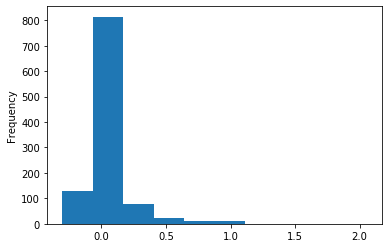

In [37]:
#histograma retornos
(df_trades['return']).plot.hist()

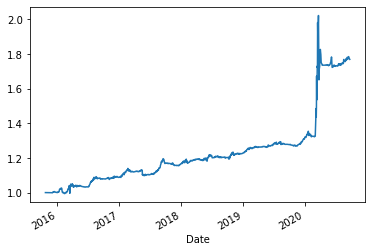

In [38]:
#retorno carteira usando MEDIA
returns['total'].plot()

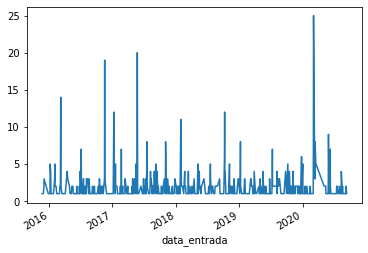

In [39]:
#quantidade trades por dia
df_trades.groupby(['data_entrada']).count()['ativo'].plot()

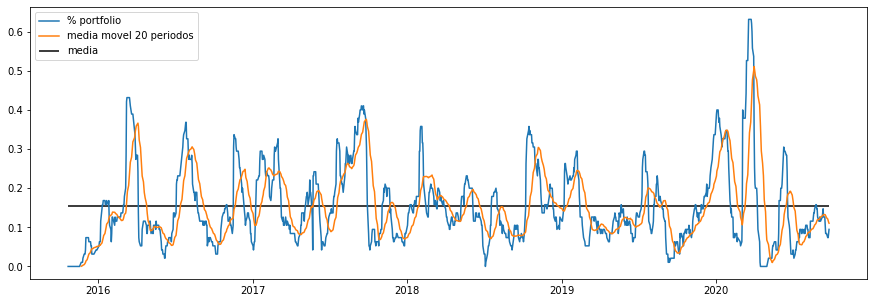

In [40]:
# grafico utilizacao do portfolio
plt.figure(figsize=(15,5))
plt.plot(df_qtd_trades.sum(axis=1)/len(portfolio.keys()), label ='% portfolio')
plt.hlines((df_qtd_trades.sum(axis=1)/len(portfolio.keys())).mean(), df_qtd_trades.index[0], df_qtd_trades.index[-1], label ='media')
plt.plot((df_qtd_trades.sum(axis=1)/len(portfolio.keys())).rolling(20).mean(), label ='media movel 20 periodos')
plt.legend()
plt.show()

In [41]:
(df_qtd_trades.sum(axis=1)/len(portfolio.keys())).mean()

0.15347936480612825

In [42]:
#bovespa para comparacao
bench = pd.DataFrame()
bench = yf.download('BOVA11.SA',start,end,interval)['Close']

[*********************100%***********************]  1 of 1 completed


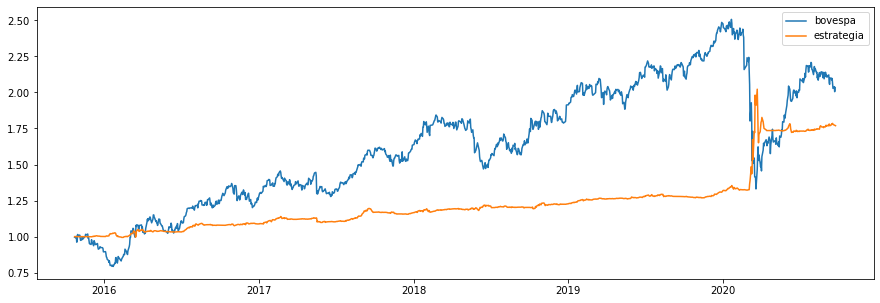

In [43]:
# grafico estrategia vs bovespa
plt.figure(figsize=(15,5))
plt.plot((bench.shift(-1)/bench).cumprod(), label ='bovespa')
plt.plot(returns['total'], label ='estrategia')
plt.legend()
plt.show()

In [44]:
#ultimos trades
df_trades.sort_values(by=['data_entrada'],ascending=False).head(15)

,ativo,direcao,data_entrada,preco_entrada,data_saida,preco_saida,periodos,return
42,AZUL4.SA,Long,2020-09-10,26.100000,2020-09-24,26.850000,10,0.028736
548,HAPV3.SA,Long,2020-09-08,67.339996,2020-09-15,66.050003,5,-0.019156
497,FLRY3.SA,Long,2020-09-08,28.459999,2020-09-24,27.850000,12,-0.021434
447,ENBR3.SA,Long,2020-09-04,18.900000,2020-09-16,18.570000,7,-0.017460
1066,YDUQ3.SA,Short,2020-09-02,27.719999,2020-09-14,30.110001,7,-0.079376
848,QUAL3.SA,Long,2020-08-27,29.830000,2020-09-18,31.969999,15,0.071740
526,GOAU4.SA,Long,2020-08-24,9.020000,2020-09-10,9.010000,12,-0.001109
755,MRFG3.SA,Long,2020-08-21,17.469999,2020-09-04,16.719999,10,-0.042931
622,JBSS3.SA,Long,2020-08-20,24.430000,2020-08-28,22.879999,6,-0.063447
408,ELET3.SA,Short,2020-08-19,31.670000,2020-08-25,38.200001,4,-0.170942


# LEVERAGE

In [45]:
kelly = trades_KPIs(df_trades)['win_ratio']- \
(1-trades_KPIs(df_trades)['win_ratio'])/trades_KPIs(df_trades)['avg_win_vs_loss']
kelly.to_list()[0]

0.3149850249468048

In [46]:
port_lev = pd.DataFrame()
for t in tickers3:
    print(t, "passthrough at ",time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    port_lev = pd.concat([port_lev,portfolio_lev(portfolio[t],t,len(tickers3),kelly.to_list()[0])],axis=1)
returns_lev = (port_lev-kelly.to_list()[0])/(1/len(tickers3))
returns_lev['total'] = returns_lev.mean(axis=1)

ABEV3.SA passthrough at  2020-09-28 21:36:42
ALPA4.SA passthrough at  2020-09-28 21:36:43
ALSO3.SA passthrough at  2020-09-28 21:36:43
AZUL4.SA passthrough at  2020-09-28 21:36:43
B3SA3.SA passthrough at  2020-09-28 21:36:43
BBAS3.SA passthrough at  2020-09-28 21:36:43
BBDC3.SA passthrough at  2020-09-28 21:36:44
BBDC4.SA passthrough at  2020-09-28 21:36:44
BBSE3.SA passthrough at  2020-09-28 21:36:44
BEEF3.SA passthrough at  2020-09-28 21:36:44
BIDI11.SA passthrough at  2020-09-28 21:36:45
BPAC11.SA passthrough at  2020-09-28 21:36:45
BPAN4.SA passthrough at  2020-09-28 21:36:45
BRAP4.SA passthrough at  2020-09-28 21:36:45
BRDT3.SA passthrough at  2020-09-28 21:36:45
BRFS3.SA passthrough at  2020-09-28 21:36:45
BRKM5.SA passthrough at  2020-09-28 21:36:46
BRML3.SA passthrough at  2020-09-28 21:36:46
BRSR6.SA passthrough at  2020-09-28 21:36:46
BTOW3.SA passthrough at  2020-09-28 21:36:46
CCRO3.SA passthrough at  2020-09-28 21:36:46
CESP6.SA passthrough at  2020-09-28 21:36:47
CIEL3.SA

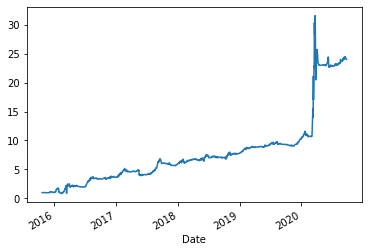

In [47]:
(returns_lev['total']+1).plot()

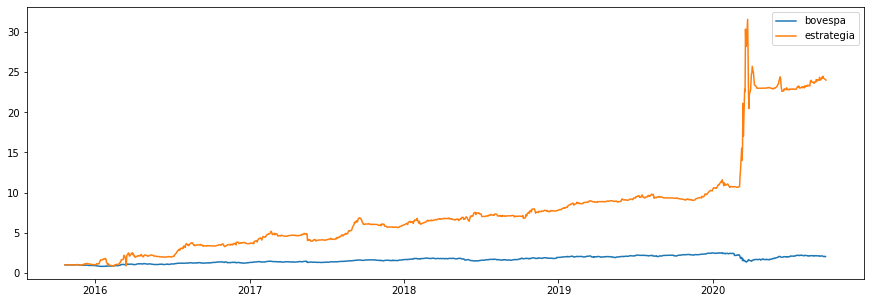

In [48]:
# grafico estrategia vs bovespa
plt.figure(figsize=(15,5))
plt.plot((bench.shift(-1)/bench).cumprod(), label ='bovespa')
plt.plot((returns_lev['total']+1), label ='estrategia')
plt.legend()
plt.show()

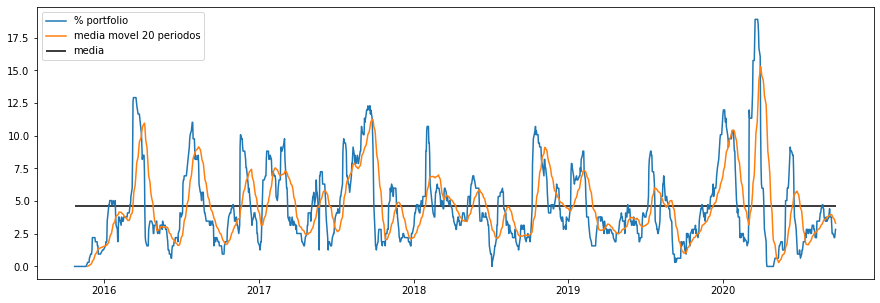

In [49]:
# grafico utilizacao do portfolio
plt.figure(figsize=(15,5))
plt.plot((df_qtd_trades.sum(axis=1)*kelly.to_list()[0]), label ='% portfolio')
plt.hlines((df_qtd_trades.sum(axis=1)*kelly.to_list()[0]).mean(), df_qtd_trades.index[0], df_qtd_trades.index[-1], label ='media')
plt.plot((df_qtd_trades.sum(axis=1)*kelly.to_list()[0]).rolling(20).mean(), label ='media movel 20 periodos')
plt.legend()
plt.show()

In [50]:
(df_qtd_trades.sum(axis=1)*kelly.to_list()[0]).mean()

4.59265164746644